In [1]:
# 이 코드는 아래 사이트에서 코드를 확인하며 진행한 예제
# https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb

In [1]:
# 고양이와 강아지를 분류해보자
# wget을 이용해 고양이와 강아지의 zip파일을 불러오자
"""!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /content/cats_and_dogs_filtered.zip"""

'!wget --no-check-certificate     https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip     -O /content/cats_and_dogs_filtered.zip'

In [2]:
# 불러온 zip파일을 압축을 풀어주자
import os
import zipfile

local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [3]:
# 기본 경로들을 설정해주어 나중에 딥러닝 때 경로를 설정해 준다
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련할 고양이와 강아지 사진 디렉토리를 각각 설정해 줌
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 검증에 사용할 사진들을 각각 디렉토리를 설정해 줌
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [4]:
# os의 하위 디렉토리를 확인하는 것을 통해 이름들을 넣어준다
train_cat_fname = os.listdir(train_cats_dir)
train_dog_fname = os.listdir(train_dogs_dir)

# 각각 1000개씩 사진 데이터 이름이 있는 것을 확인할 수 있음
print(len(train_cat_fname))
print(len(train_dog_fname))

1000
1000


In [5]:
# 모델 구성을 위해 케라스의 레이어와 모델을 불러옴
from tensorflow.keras import layers
from tensorflow.keras import Model

In [9]:
# 사용할 이미지의 가로세로 150픽셀이며, RGB 3가지를 위해 3개 속성을 냅둠
img_input = layers.Input(shape=(100, 100, 3))

# 내가 참고한 강의 자료에 따르면 Sequential 모델을 두고,
# 거기에 add 해주는 방식이었는데 얘는 x 변수에 차곡차곡 쌓는 방식(같음)
# 2D 형태로 만들어 주어 MaxPooling2D로 크기를 축소해 효율성 챙김
x = layers.Conv2D(16, (3, 3), activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
# x = layers.MaxPooling2D(pool_size=(2, 2))

x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2)(x)


In [10]:
# Flattern을 통해 차원을 1차원으로 만듦
x = layers.Flatten()(x)

# 오버피팅이 일어나기 전까지 계속 돌림(?)
x = layers.Dense(512, activation='relu')(x)

# binary 분류의 최종 activation은 sigmoid임
output = layers.Dense(1, activation='sigmoid')(x)

# 강의와 다르게 여기서는 다 만들고 모델에 집어 넣음
model = Model(img_input, output)

In [11]:
# 지금까지 만든 모델 확인
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 64)        0   

In [14]:
from tensorflow.keras.optimizers import RMSprop

# 학습률이 0.001인 RMSprop를 사용함
# RMSprop는 학습 속도 조정을 자동화 하여 SGD보다 용이함
# 강아지와 고양이 둘 중 가까운 곳을 고르면 되기 때문에 binary
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지의 배율을 1/255로 함
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

# batch_size를 20으로 하여 적당한 타이밍에 해답 확인(가중치 갱신)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=20,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(100, 100),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [16]:
# 가공된 데이터를 모델에 대입해 트레이닝을 하는 과정
# 15번 반복하여 학습할 것이며, 위에서 지정한 배치 사이즈를 100번 단위로 진행
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Epoch 1/15
100/100 - 17s - loss: 0.6849 - acc: 0.5890 - val_loss: 0.6634 - val_acc: 0.6090
Epoch 2/15
100/100 - 6s - loss: 0.6203 - acc: 0.6680 - val_loss: 0.5947 - val_acc: 0.7000
Epoch 3/15
100/100 - 6s - loss: 0.5493 - acc: 0.7390 - val_loss: 0.5642 - val_acc: 0.7150
Epoch 4/15
100/100 - 6s - loss: 0.4855 - acc: 0.7720 - val_loss: 0.6403 - val_acc: 0.6790
Epoch 5/15
100/100 - 6s - loss: 0.4135 - acc: 0.8035 - val_loss: 0.7516 - val_acc: 0.6650
Epoch 6/15
100/100 - 7s - loss: 0.3436 - acc: 0.8405 - val_loss: 0.6596 - val_acc: 0.7080
Epoch 7/15
100/100 - 6s - loss: 0.2939 - acc: 0.8800 - val_loss: 1.0980 - val_acc: 0.6360
Epoch 8/15
100/100 - 7s - loss: 0.2271 - acc: 0.9085 - val_loss: 0.7867 - val_acc: 0.7040
Epoch 9/15
100/100 - 6s - loss: 0.1540 - acc: 0.9395 - val_loss: 0.8927 - val_acc: 0.7050
Epoch 10/15
100/100 - 6s - loss: 0.1320 - acc: 0.9515 - val_loss: 0.8503 - val_acc: 0.7170
Epoch 11/15
100/100 - 6s - loss: 0.0909 - acc: 0.9635 - val_loss: 1.0620 - val_acc: 0.7030
Epoch 1

99.9% 확률로 냥냥이


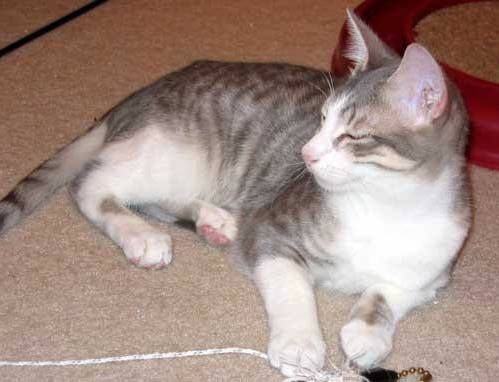

In [28]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
from IPython.display import Image

# 냥냥이와 댕댕이의 모든 사진의 이름을 리스트로 저장함
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fname]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fname]
#img_path = "/content/6.png"
img_path = random.choice(cat_img_files + dog_img_files)

# 이미지 디렉토리에서 불러온 사진을 사이즈를 축소해 저장
img = load_img(img_path, target_size=(100, 100))
x = img_to_array(img)

x = x.reshape((1,) + x.shape)
x /= 255

# y에 이미지에 대한 최종적인 내용을 넣어줌
y = model.predict(x)[0][0]
y = round(float(y), 3)

# binary라 y가 높을수록 멍멍이, 낮을수록 냥냥이
if y > 0.5:
  print(str(y*100) + "% 확률로 멍멍이")
else :
  print(str((1-y) * 100) + "% 확률로 냥냥이")
Image(filename=img_path)


In [29]:
# 이하 단계적인 이미지 특징 검출 과정을 plt로 나타낸 것
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_mode = Model(img_input, successive_outputs)

SSsuccessive_feature_maps = visualization_mode.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

NameError: name 'successive_feature_maps' is not defined

Text(0.5, 1.0, 'Training and validation loss')

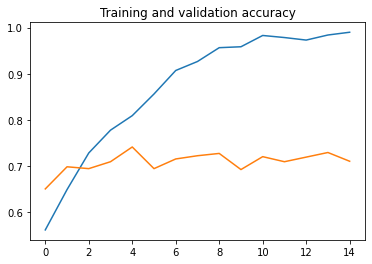

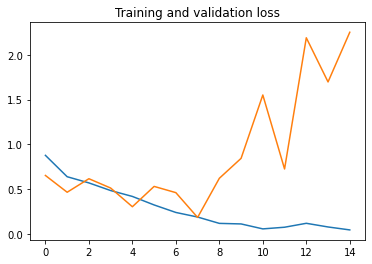

In [150]:
# history에 저장한 결과값들을 활용해 정확도와 loss 비율을 그래프로 나타냄
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')